# Monitoring of Structural Health and Geohazards
## CEGM2008

In [4]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import plotly.graph_objects as go
import plotly.express as px

### Importing the measurements

In [5]:
data = pd.read_csv('accelerations.csv', header=0)
data = data.to_numpy()  # convert to numpy array
t = pd.read_csv('t.csv', header=0)
t = t.to_numpy().flatten() # convert to 1D array

data.shape, t.shape

((32768, 35), (32768,))

### Properties of the data

In [6]:
n_d = len(data[0])  # number of sensors
dt = t[1] - t[0]    # time step
F = 1 / dt          # sampling frequency
N = len(t)          # number of time samples
df = F / N          # frequency resolution

data_omega = fft(data, axis=1)

### Plotting the data

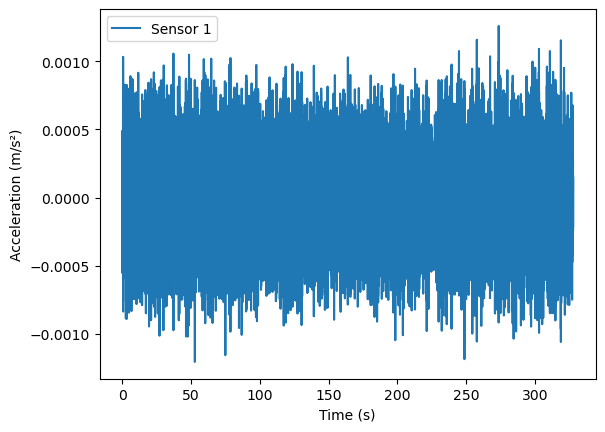

In [22]:
for i in range(1):
    plt.plot(t, data[:, i], label=f'Sensor {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.show()

### System Identification: frequency domain decomposition
#### Segment the data

In [ ]:
# Split the data into 'n_seg' segments and perform the FFT for each segment
n_seg = 5
# New sampling parameters
N_seg = N / n_seg
N_seg_counter = int(N_seg/2) # again only the positive frequencies
t_seg = np.arange(0, N_seg, dt)
F = 1 / dt
df_seg = F/N_seg
freq_seg = np.arange(0, F/2, df_seg)

# Split the data
data_split = np.array_split(data, n_seg)
# Store all segments in a list
data_seg = [data_split[i] for i in range(n_seg)]
data_seg_fft = [fft(data_seg[i], axis=0) for i in range(n_seg)]
print(data_seg_fft[0].shape) # Check the shape of each matrix in the list

(6554, 35)


c:\Users\Nigel\miniconda3\envs\CIEM5000\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



### Approximate the output spectral density matrix and decompose it using a SVD

In [ ]:
# Initialize matrices for storing the singular values en left/right singular vectors at each frequency
U_omega = np.zeros((N_seg_counter, n_d, n_d), dtype=np.complex128)
V_omega = np.zeros((N_seg_counter, n_d, n_d), dtype=np.complex128)
S_omega = np.zeros((n_d, N_seg_counter))

# Approximate the output spectral density matrix (Sdd) and decompose
for i in range(N_seg_counter):
     Sdd = np.zeros((n_d, n_d), dtype=np.complex128)
     for seg in data_seg_fft: # Looping over the segments to calculate Sdd as an average
          arr_seg = np.reshape(seg[i, :], (n_d, 1)) # reshape the applicable row in the list to a 10x1 array
          Sdd += arr_seg @ np.conj(arr_seg.T)  # (n_d, n_d)
     
     U, S, V = np.linalg.svd(Sdd) # Perform the SVD
     U_omega[i] = U
     V_omega[i] = V
     S_omega[:, i] = S

In [ ]:
# Plot the singular values
fig = go.Figure()
for sv in range(len(S_omega)):
    fig.add_trace(go.Scatter(x=freq_seg[:np.size(S_omega, axis=1)], y=S_omega[sv, :], name=f'Singular value {sv+1}', line=dict(width=2)))

fig.update_yaxes(type="log")

fig.update_layout(
    xaxis=dict(title="Frequency [Hz]"),
    yaxis=dict(title="Singular values"),
    showlegend=False)

fig.show()


### Extract the eigenfrequencies and eigenvectors

In [ ]:
# Select eigenfrequencies from the figure above
freq1 = 20.6
freq2 = 127
freq3 = 369
freq4 = 731
freq5 = 1207

# Find the indices of the eigenfrequencies and store them in a list
index_1 = np.where(freq_seg > freq1)[0][0]
index_2 = np.where(freq_seg > freq2)[0][0]
index_3 = np.where(freq_seg > freq3)[0][0]
index_4 = np.where(freq_seg > freq4)[0][0]
index_5 = np.where(freq_seg > freq5)[0][0]
indices = [index_1, index_2, index_3, index_4, index_5]